In [76]:
%matplotlib inline


# Comparing different clustering algorithms on toy datasets


This example shows characteristics of different
clustering algorithms on datasets that are "interesting"
but still in 2D. With the exception of the last dataset,
the parameters of each of these dataset-algorithm pairs
has been tuned to produce good clustering results. Some
algorithms are more sensitive to parameter values than
others.

The last dataset is an example of a 'null' situation for
clustering: the data is homogeneous, and there is no good
clustering. For this example, the null dataset uses the
same parameters as the dataset in the row above it, which
represents a mismatch in the parameter values and the
data structure.

While these examples give some intuition about the
algorithms, this intuition might not apply to very high
dimensional data.



In [77]:
file_path = 'C:/Users/liwu/XstoreLogProject/data'
file_name = 'xstore_error_log_timevec.csv'
result_file_name = 'clustering_result.csv'

In [78]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer

np.random.seed(0)

def process_dataset(file_path):
    errorLog = pd.read_csv(file_path)
    errorLog['oracle_error_code'] = errorLog.oracle_error_code.astype('category')

    errorLog['error_cat'] = errorLog.oracle_error_code.cat.codes
    errorLog['timevec'] = errorLog.timevec.apply(lambda x: np.array(list(map(float,x[1:-1].split(',')))))

    data = errorLog.timevec.values
   
    target = errorLog.error_cat.values
    #feature = errorLog.oracle_error_code.values

    #errorLogBunch = datasets.base.Bunch(data = data, target = target,feature = feature)
    errorLogBunch = pd.DataFrame(data = {"data" : errorLog.timevec, "target": errorLog.error_cat, 
                                         'feature': errorLog.oracle_error_code,
                                            'desc':errorLog.desc})

    return errorLogBunch

ds = process_dataset(file_path + '/' + file_name)





Automatically created module for IPython interactive environment


In [79]:
desc_file = file_path + '/' + ''
def find_description(desc_file, code):
    df = pd.read_csv(desc_file)

    

c:\users\liwu\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:57: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 3600x2880 with 0 Axes>

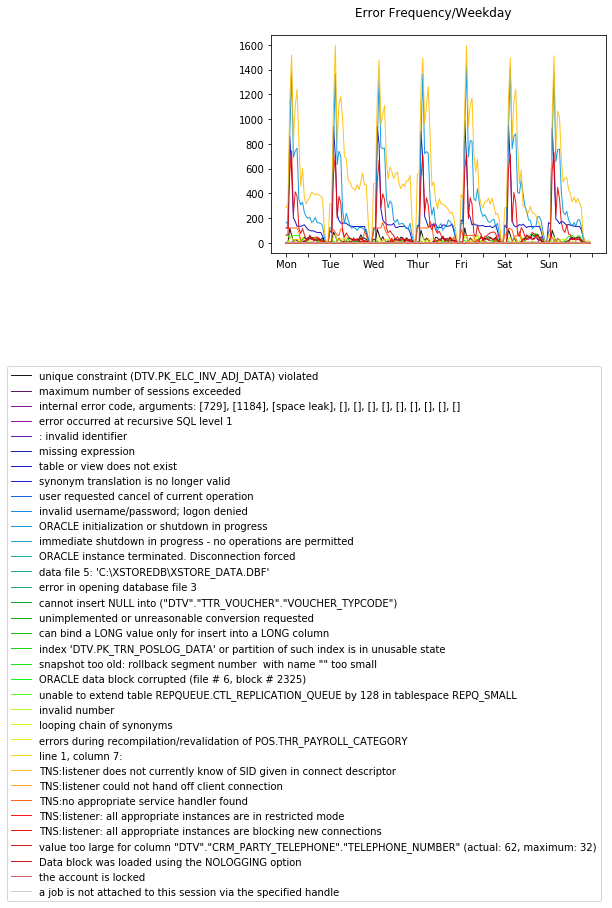

In [80]:
# ============
# Set up cluster parameters
# ============
plt.figure(1,figsize=(50, 40))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)



#####TODO: modify these paramtres

default_base = {'quantile': .25,
                'eps': 50,
                'damping': .9,
                'preference': -5000,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 2,
                'xi': 0.05,
                'min_cluster_size': 0.1}


# update parameters with dataset-specific values
params = default_base.copy()



# preprocess dataset, split into training and test part
X = ds['data'].values
###convert the type to np float inside
X = np.vstack(X[:])

y = ds.target.values
y_feature = ds.feature.values
y_desc = ds.desc.values

def plot_raw(X_raw, y_raw):
    '''
    Plot the untransformed and unclustered raw dataset with label.
    X_raw:
    y_raw:
    '''
    
    fig = plt.figure(2)
    raw_fig = plt.subplot()
    palette = plt.cm.get_cmap('nipy_spectral', len(y_raw))


    for row in range(X_raw.shape[0]):
       
        plt.plot(X[row], marker='', linewidth=1, color = palette(row),alpha=0.9, label = y_raw[row])
    raw_fig.set_xticks(np.arange(0, 169, 12))
    labels = ['Mon', '','Tue','', 'Wed','', 'Thur','', 'Fri','', 'Sat','', 'Sun']
    raw_fig.set_xticklabels(labels)
    plt.legend(bbox_to_anchor = (1,-0.5))
    fig.suptitle('Error Frequency/Weekday')
    fig.show()
    return 

plot_raw(X,y_desc)





In [81]:
X =  TfidfTransformer(smooth_idf=False).fit_transform(X)
    

c:\users\liwu\appdata\local\programs\python\python37\lib\site-packages\sklearn\feature_extraction\text.py:1278: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.log(n_samples / df) + 1


In [82]:
#X = StandardScaler().fit_transform(X)


#normalize dataset for easier parameter selection
#X = StandardScaler().fit_transform(X)

# estimate bandwidth for mean shift
bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

# connectivity matrix for structured Ward
connectivity = kneighbors_graph(
    X, n_neighbors=params['n_neighbors'], include_self=False)
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

# ============
# Create cluster objects
# ============



ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)

dbscan = cluster.DBSCAN(eps = params['eps'])
optics = cluster.OPTICS(min_samples=params['min_samples'],
                        xi=params['xi'],
                        min_cluster_size=0.01)
affinity_propagation = cluster.AffinityPropagation(
damping=params['damping'], preference=params['preference'])

clustering_algorithms = {
    'MiniBatchKMeans':[],
    'AffinityPropagation': [affinity_propagation],
    'MeanShift': [ms],
    'SpectralClustering':[],
    'Ward':[],
    'AgglomerativeClustering':[],
    'DBSCAN': [dbscan],
    'OPTICS':[optics],
    'Birch':[],
    'GaussianMixture':[]
}



range_n_cluster = range(1,34)
for i in range_n_cluster:
    clustering_algorithms['MiniBatchKMeans'].append(cluster.MiniBatchKMeans(n_clusters= i))
    clustering_algorithms['AgglomerativeClustering'].append( cluster.AgglomerativeClustering(
    linkage="average", affinity="cityblock",
    n_clusters = i , connectivity=connectivity))
    clustering_algorithms['Birch'].append(cluster.Birch(n_clusters=i))
    clustering_algorithms['GaussianMixture'].append( mixture.GaussianMixture(
    n_components=i, covariance_type='full'))
    clustering_algorithms['Ward'].append(cluster.AgglomerativeClustering(
    n_clusters=i, linkage='ward',
    connectivity=connectivity))
    clustering_algorithms['SpectralClustering'].append(cluster.SpectralClustering(
    n_clusters=i, eigen_solver='arpack',
    affinity="nearest_neighbors"))
    
    


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [83]:
def num_cluster_comparison(range_n, algo_list, algo_name):
    '''
    Compare the number of clusters for algorithms.
    Currently supporting Kmeans.
    '''
    global X
    global y
    global y_feature
    global y_desc
    
    print(X)
    print(y)
    print(X.shape)
    print(y.shape)
    Sum_of_squared_distances = []
    for K, algorithm in zip(range_n,algo_list):
        algorithm.fit(X)

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
            
        Sum_of_squared_distances.append(algorithm.inertia_)
        
    plt.plot(range_n,Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    return








    

    
#plt.show()    
    
#====
#Evaluation of performance 
#====

# metrics.silhouette_score(X, labels, metric='euclidean')

  (0, 165)	0.005554069552074191
  (0, 163)	0.01990362393876296
  (0, 162)	0.022885666122507434
  (0, 161)	0.08087580502002986
  (0, 160)	0.0924294914514627
  (0, 159)	0.06354527537288061
  (0, 158)	0.05383228966005292
  (0, 157)	0.08800364972147817
  (0, 156)	0.08114008897979909
  (0, 155)	0.030001244223231194
  (0, 154)	0.035368756734784214
  (0, 153)	0.014217581314427137
  (0, 152)	0.006791171221937676
  (0, 151)	0.0071087906572135685
  (0, 150)	0.054500728371970696
  (0, 149)	0.09177469277304201
  (0, 148)	0.013582342443875352
  (0, 147)	0.13506702248705782
  (0, 146)	0.20400846071797213
  (0, 145)	0.002263723740645892
  (0, 144)	0.002369596885737856
  (0, 141)	0.004335899662221957
  (0, 140)	0.03328824163273809
  (0, 139)	0.075240199370885
  (0, 138)	0.14563605714322914
  :	:
  (31, 16)	0.08069728662194284
  (31, 15)	0.0973823179974236
  (31, 14)	0.1439832098018052
  (31, 13)	0.18085287628092955
  (31, 12)	0.10045340218730597
  (31, 11)	0.03873469757853256
  (31, 10)	0.074791302351

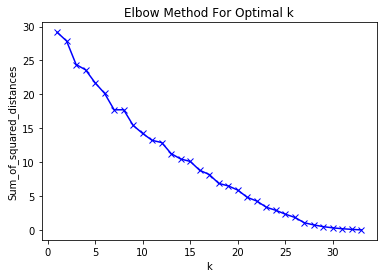

ValueError: setting an array element with a sequence.

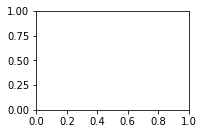

In [85]:
def fit_and_plot_result(name,algorithm, total_plot):
    
    global plot_num
    global X
    global y
    global y_feature
    global y_desc
    
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
        "ignore",
        message="the number of connected components of the " +
        "connectivity matrix is [0-9]{1,2}" +
        " > 1. Completing it to avoid stopping the tree early.",
        category=UserWarning)
    warnings.filterwarnings(
        "ignore",
        message="Graph is not fully connected, spectral embedding" +
        " may not work as expected.",
        category=UserWarning)
    algorithm.fit(X)

    t1 = time.time()
    if hasattr(algorithm, 'labels_'):
        y_pred = algorithm.labels_.astype(np.int)
    else:
        y_pred = algorithm.predict(X)
    
    #Plot set up 
    ax = plt.subplot(2, total_plot/2, plot_num)
 
    
     

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                         '#f781bf', '#a65628', '#984ea3',
                                         '#999999', '#e41a1c', '#dede00']),
                                  int(max(y_pred) + 1))))
    
    #text result description
    algo_name = name
    num_cluster = max(y_pred) + 1
    
    with open(file_path + '/' + result_file_name,'a') as f:
        f.write("Algorithm {} generates {} clusters.\n".format(algo_name, num_cluster))
        f.close()
    
    # add black color for outliers (if any)
    colors = np.append(colors, ["#000000"])
    
    #Text Result
    for pred in np.unique(y_pred):
        for row in range(X.shape[0]):
            error_code = y_feature[row]
            error_desc = y_desc[row]
            cluster_id = y_pred[row]
            if cluster_id == pred:
                #print("Cluster {}: Error {} : {} ".format(cluster_id, error_code, error_desc))
                with open(file_path + '/' + result_file_name,'a') as f:
                    f.write("Cluster {}: Error {} : {}.\n ".format(cluster_id, error_code, error_desc))
                    
                
                
    #Visual Result
    for row in range(X.shape[0]):
        ax.plot(X[row], marker='', color=colors[y_pred[row]], linewidth=1, alpha=0.9 )

    ax.set_xticks(np.arange(0, 169, 24))
    ax.set_xlim(0, 169)
    ax.set_ylim(0, 1700)
    labels = ['Mon', '','Tue','', 'Wed','', 'Thur','', 'Fri','', 'Sat','', 'Sun']
    ax.set_xticklabels(labels)
   
    #ax.set_yticks(())
    plt.text(0.01, 0.90,name,transform=plt.gca().transAxes,size=10)
    plt.text(.99, .70, str(num_cluster) + " clusters" ,
             transform=plt.gca().transAxes, size=10,
             horizontalalignment='right')
    plot_num += 1
    return

plot_num = 1 


for name, algorithms in clustering_algorithms.items():
    if len(algorithms) != 1:
        if name == 'MiniBatchKMeans':
            num_cluster_comparison(range_n_cluster, algorithms, name) 
        continue
    else:
        fit_and_plot_result(name,algorithms[0],4)



In [ ]:
#
i = 4

num_clustering_algorithms = {
    'MiniBatchKMeans':[],
    'SpectralClustering':[],
    'Ward':[],
    'AgglomerativeClustering':[],
    'Birch':[],
    'GaussianMixture':[]
}

num_clustering_algorithms['MiniBatchKMeans'].append(cluster.MiniBatchKMeans(n_clusters= i))
num_clustering_algorithms['AgglomerativeClustering'].append( cluster.AgglomerativeClustering(
linkage="average", affinity="cityblock",
n_clusters = i , connectivity=connectivity))
num_clustering_algorithms['Birch'].append(cluster.Birch(n_clusters=i))
num_clustering_algorithms['GaussianMixture'].append( mixture.GaussianMixture(
n_components=i, covariance_type='full'))
num_clustering_algorithms['Ward'].append(cluster.AgglomerativeClustering(
n_clusters=i, linkage='ward',
connectivity=connectivity))
num_clustering_algorithms['SpectralClustering'].append(cluster.SpectralClustering(
n_clusters=i, eigen_solver='arpack',
affinity="nearest_neighbors"))

plot_num = 1
for name, algorithm in num_clustering_algorithms.items():
    fit_and_plot_result(name,algorithm[0],6)

